In [1]:
import tensorflow as tf
import numpy as np
import h5py
from scipy.ndimage.measurements import center_of_mass

from matplotlib import pyplot as plt

from lib.VAE import CVAE
import lib.data as hd

# workaround for strange tf behaviour inside containers...
#physical_devices = tf.config.experimental.list_physical_devices('GPU')
#tf.config.experimental.set_memory_growth(physical_devices[0], True)

# set the precision
tf.keras.backend.set_floatx('float32')

# Set options

In [2]:
# Set this to true if you wish to save a new trasformed dataset
save_results = True

# Setup plotting

In [3]:
phase_ticks = np.arange(-180, 181, 45)
freq_limit_low = 5.1
freq_limit_high = 7.8
ticks_pi = np.linspace(-np.pi, np.pi, 9)
ticks_pi_deg = ticks_pi * 180/np.pi

In [4]:
face_colors = {
    'orange': [0.8906, 0.4609, 0.4062],
    'gray': [0.6523, 0.6484, 0.6484],
    'blue': [0.5156, 0.5977, 0.8789]
}
edge_colors = {
    'orange': [0.9961, 0, 0],
    'gray': [0.4805, 0.4766, 0.4766],
    'blue': [0, 0, 0.9961]
}

edge_colors_arr = [ec for ec in edge_colors.values()]
face_colors_arr = [fc for fc in face_colors.values()]

cycler = (plt.cycler(mec=edge_colors_arr)+
          plt.cycler(mfc=face_colors_arr)+
          plt.cycler(color=edge_colors_arr))

In [5]:
plt.rcParams.update({
    'figure.figsize': (12, 8),
    'font.size': 20,
    'lines.markeredgewidth': 2,
    'lines.markersize': 9,
    'lines.marker': 'o',
    'lines.linestyle': '',
    'lines.linewidth': 3,
    'axes.prop_cycle': cycler
    })

# Load and prepare data
Here we load the corresponding data. The data gets normalized to a domain between 0 and 1 for each image individually. We also set the path to the rephased images, since they are needed for the following parts in the paper.

In [6]:
source_path = 'data/single_cut_56.h5'
dest_path = 'data/single_cut_rephased.h5'
images, data = hd.load_dataset(source_path,
                               ['micromotion_phase', 'freq'])
mmphase = data['micromotion_phase']
images = hd.normalize_single_images(images)
images = hd.prepare_images_tensorflow(images)

# Load the trained models
To train the models run 3b_train_micromotion_VAE.py

In [7]:
encoder = tf.keras.models.load_model('trained_networks/IIIb_VAE_micromotion_encoder.h5')
decoder = tf.keras.models.load_model('trained_networks/IIIb_VAE_micromotion_decoder.h5')
latent_dim = int(encoder.layers[-1].units / 2)
encoder.summary()
decoder.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
en_conv_0 (Conv2D)           (None, 56, 56, 90)        1530      
_________________________________________________________________
batch_normalization (BatchNo (None, 56, 56, 90)        360       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 56, 56, 90)        0         
_________________________________________________________________
en_pool_0 (MaxPooling2D)     (None, 14, 14, 90)        0         
_________________________________________________________________
en_conv_1 (Conv2D)           (None, 14, 14, 50)        162050    
_________________________________________________________________
batch_normalization_1 (Batch (None, 14, 14, 50)        200       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 14, 14, 50)        0

In [8]:
model = CVAE(latent_dim, encoder, decoder)

/opt/sw/python/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:1: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  """Entry point for launching an IPython kernel.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


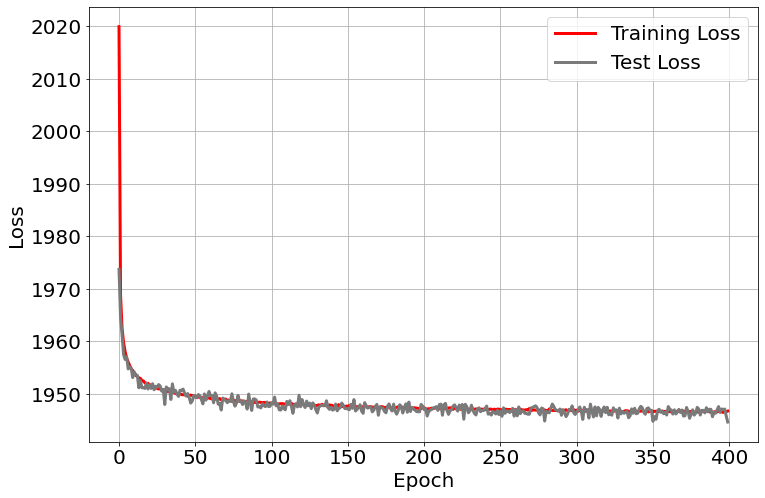

In [9]:
with h5py.File('trained_networks/IIIb_VAE_micromotion_history.h5') as history_file:
    plt.plot(history_file['train_loss'], label='Training Loss', marker='', linestyle='-')
    plt.plot(history_file['test_loss'], label='Test Loss', marker='', linestyle='-')
    plt.legend()
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid()
    plt.savefig("plots/IIIb/learning_curve.eps", bbox_inches='tight')
    plt.show()

# Transform data

Create a batched dataset to respect GPU memory. If you do not use a GPU you noramlly have free choice.

In [10]:
dataset = tf.data.Dataset.from_tensor_slices((images, mmphase)).batch(200)

In [11]:
def rephase_images(phase_shift):
    rephased_images = np.empty((0, 56, 56))
    for b_images, b_mmphase in dataset:
        b_rephased_images = model.dephase(b_images, -b_mmphase + phase_shift).numpy()
        b_rephased_images = np.squeeze(b_rephased_images)
        rephased_images = np.append(rephased_images, b_rephased_images, 0)
    return rephased_images

## Actual rephasing
Here the data gets rephased to micromotion phase of 0.

In [12]:
rephased_images = np.empty((0, 56, 56))
for b_images, b_mmphase in dataset:
    b_rephased_images = model.dephase(b_images, -b_mmphase).numpy()
    b_rephased_images = np.squeeze(b_rephased_images)
    rephased_images = np.append(rephased_images, b_rephased_images, 0)

# Save rephased dataset

In [13]:
if save_results:
    with h5py.File(dest_path, 'w') as dest_file:
        with h5py.File(source_path, 'r') as source_file:
            source_file.copy('parameter', dest_file)
            dest_file['images'] = rephased_images

# Plot samples

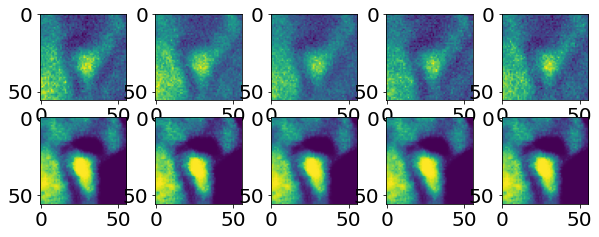

<Figure size 864x576 with 0 Axes>

In [14]:
pick_freq = 7.4
selection_map = np.where((data['freq'] == pick_freq))[0]

displayimages_x = np.squeeze(images[selection_map])
original_mm_phase_display = data['micromotion_phase'][selection_map]
displayimages_y = rephased_images[selection_map]

fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(2*5, 3.5))
for i in range(5):
    ax[0,i].imshow(np.squeeze(displayimages_x[i]))
    ax[1,i].imshow(np.squeeze(displayimages_y[i]))
plt.show()

for i in range(5):
    plt.imshow(np.squeeze(displayimages_x[i]))
    plt.axis('off')
    plt.clim(np.min(displayimages_x), np.max(displayimages_x))
    plt.colorbar()
    plt.clf()
    
    plt.imshow(np.squeeze(displayimages_y[i]))
    plt.axis('off')
    plt.clim(np.min(displayimages_y), np.max(displayimages_y))
    plt.colorbar()
    plt.clf()

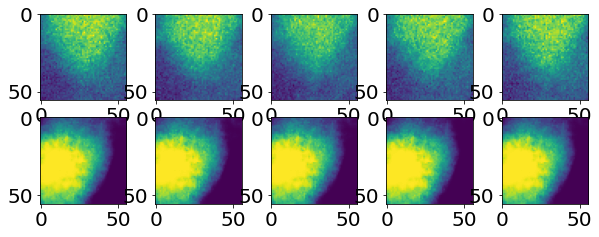

<Figure size 864x576 with 0 Axes>

In [15]:
pick_freq = 5.8
selection_map = np.where((data['freq'] == pick_freq))[0]

displayimages_x = np.squeeze(images[selection_map])
original_mm_phase_display = data['micromotion_phase'][selection_map]
displayimages_y = rephased_images[selection_map]

fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(2*5, 3.5))
for i in range(5):
    ax[0,i].imshow(np.squeeze(displayimages_x[i]))
    ax[1,i].imshow(np.squeeze(displayimages_y[i]))
plt.show()

for i in range(5):
    plt.imshow(np.squeeze(displayimages_x[i]))
    plt.axis('off')
    plt.clim(np.min(displayimages_x), np.max(displayimages_x))
    plt.colorbar()
    plt.clf()
    
    plt.imshow(np.squeeze(displayimages_y[i]))
    plt.axis('off')
    plt.clim(np.min(displayimages_y), np.max(displayimages_y))
    plt.colorbar()
    plt.clf()